OLS & PLS Regressions and Predictions
==================================
This notebook uses the `sklearn` library to run some machine learning
predictions using regression analysis. It has examples of both
Ordinary Least Square and Partial Least Square Regression.

We look at school demographics to see how well we can use those factors
to predict mean_scale_score. We look at the grades 3-8 NYS math exams
for the most recent academic year in our data set.

If it is not installed, you will need to install `sklearn`:

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
pip install sklearn
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~


In [1]:
# automatically reload changes we make to schools.py and ui.py
%load_ext autoreload
%autoreload 2

# load the demographic data
import pandas as pd

import numpy as np


from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import scale 
from sklearn.cross_decomposition import PLSRegression


import matplotlib.pyplot as plt
import seaborn as sns
import math

from IPython.display import Markdown as md

from school_data import schools, ui, exams


In [2]:
# load the demographic data and merge it with the math data
df = schools.load_school_demographics()

math_df = exams.load_math()

math_df = df.merge(math_df, how="inner", on=["dbn", "ay"])
math_df = math_df[math_df["mean_scale_score"].notnull()]


Predicting test scores
-------------------------------
Using OLS regression we will see how well we can predict mean_scale_score for the
"All Students" category. We will run this with several variations of factors
to see which factors have the strongest prediction.

The basic ideas of a predictive model is that we will use some of our data to
"train" the model and use the other portion to "test" the model. Once we
calculate a coeefficient for each factor, we can use those values to
adjust the data sets mean score for a particular case.

These examples will use two statistical measures to compare our models:

- r-squared is a number between 0 and 1 that will tell us how closely our predictions
  match the actual recorded score (1 is perfect, 0 is no matches)
- mean squared error (`rmse`) tells us the mean distance between predictions and recorded scores
  in the same scale as our exam; so an rmse of 10 means that, on average, our predictions were
  10 points away from the actual score


### Correlation table
First, let's see how the factors correlate with each other, and with our
dependent variable. This table uses a "coolwarm" color map. Darker red
indicates a strong positive correlation and darker blue a strong negative correlation.


**Descriptive statistics for mean scale score**

,mean_scale_score
count,5714.000000
mean,600.680750
std,11.329087
min,565.111084
25%,592.029709
50%,599.779266
75%,608.331512
max,639.000000


**Correlation table between factors and mean scale score**

,mean_scale_score,total_enrollment,asian_pct,black_pct,hispanic_pct,white_pct,swd_pct,ell_pct,poverty_pct,charter,eni_pct,district
eni_pct,-0.590737,-0.186478,-0.285463,0.266523,0.544876,-0.794295,0.385043,0.446102,0.952938,0.048488,1.000000,0.000554
poverty_pct,-0.555660,-0.160478,-0.260532,0.315965,0.490648,-0.814028,0.321996,0.410576,1.000000,0.093889,0.952938,0.077837
swd_pct,-0.549075,-0.365178,-0.349036,0.109240,0.266018,-0.177316,1.000000,0.042266,0.321996,-0.259609,0.385043,-0.309815
hispanic_pct,-0.343126,-0.072222,-0.330903,-0.419660,1.000000,-0.380352,0.266018,0.526813,0.490648,-0.051718,0.544876,-0.135115
ell_pct,-0.268894,0.092477,0.189464,-0.423749,0.526813,-0.215471,0.042266,1.000000,0.410576,-0.236553,0.446102,-0.231065
black_pct,-0.240674,-0.286883,-0.455616,1.000000,-0.419660,-0.475151,0.109240,-0.423749,0.315965,0.336198,0.266523,0.324982
total_enrollment,0.293220,1.000000,0.363721,-0.286883,-0.072222,0.185958,-0.365178,0.092477,-0.160478,0.003416,-0.186478,0.076347
charter,0.297497,0.003416,-0.230401,0.336198,-0.051718,-0.203052,-0.259609,-0.236553,0.093889,1.000000,0.048488,0.947229
district,0.308673,0.076347,-0.133237,0.324982,-0.135115,-0.163201,-0.309815,-0.231065,0.077837,0.947229,0.000554,1.000000
asian_pct,0.388405,0.363721,1.000000,-0.455616,-0.330903,0.182161,-0.349036,0.189464,-0.260532,-0.230401,-0.285463,-0.133237


**Scatter plots of correlations showing covariance of factors**

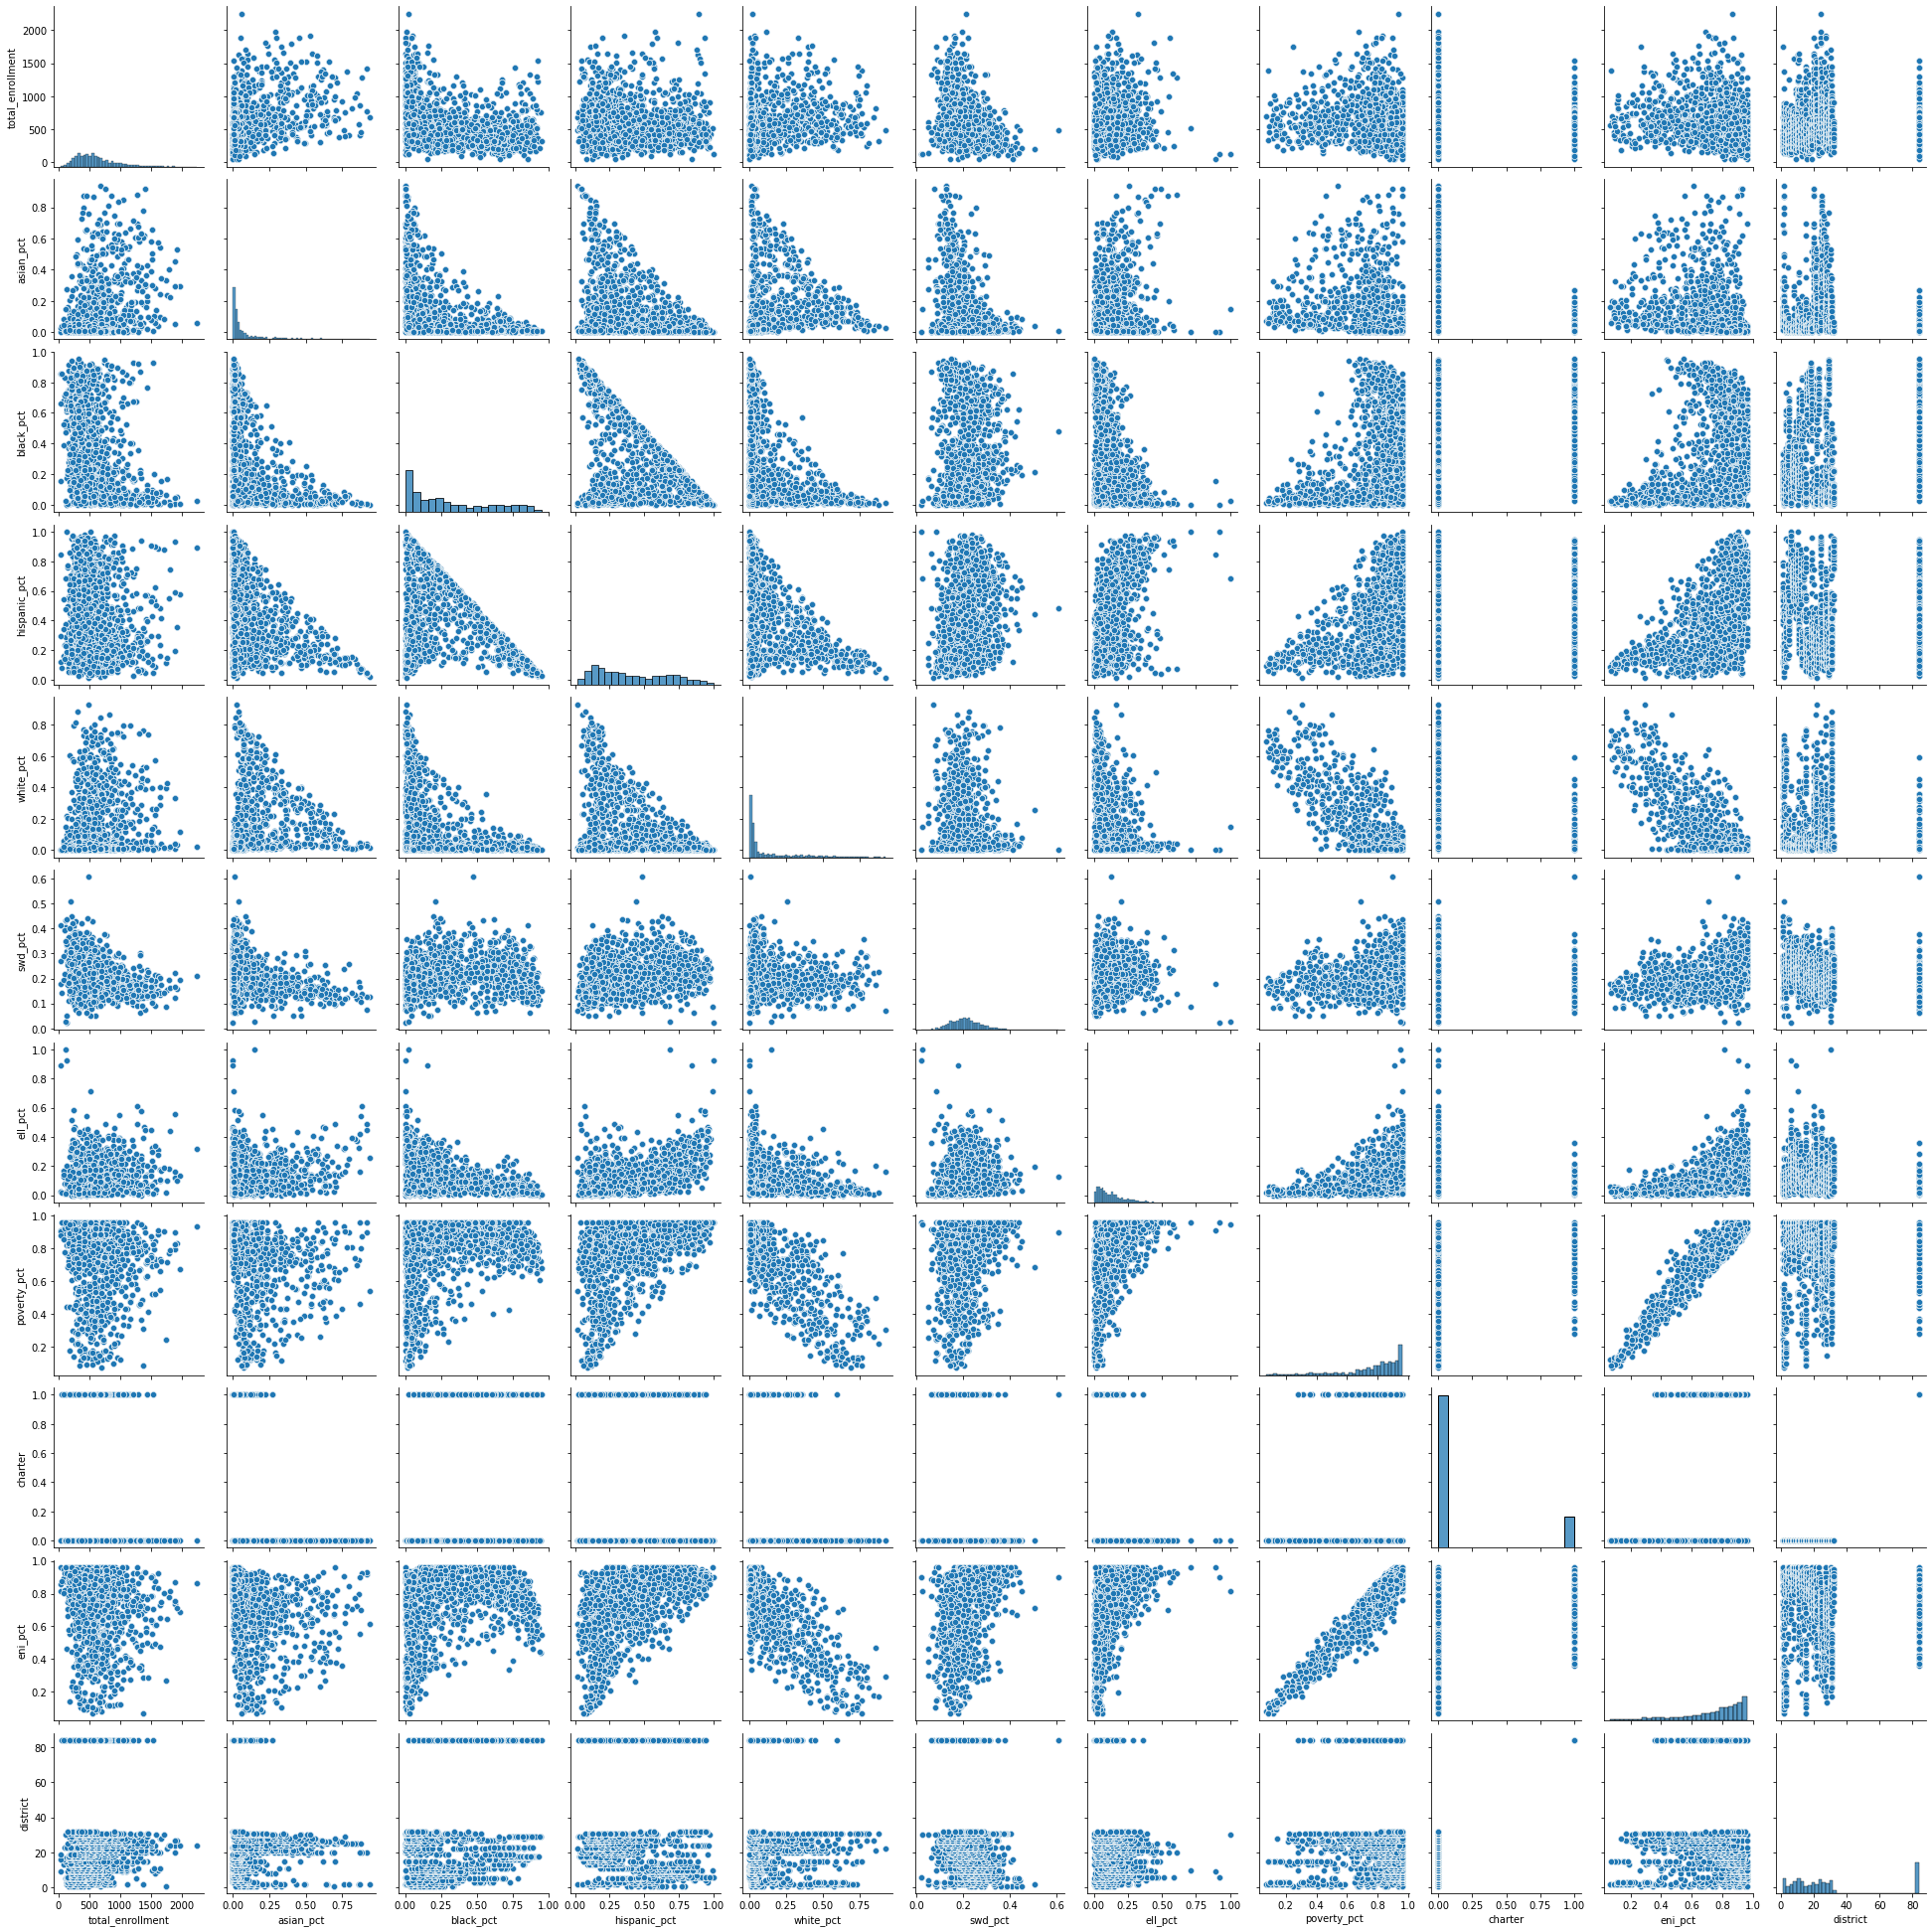

In [3]:
# get just the 2019 test results for All Students
# this will be the dependent variable in our regression
data = math_df.query(f"ay == {math_df.ay.max()} and category == 'All Students'")
# calculate coefficients for these factors
factors = ['total_enrollment', 'asian_pct','black_pct', 
       'hispanic_pct',  'white_pct','swd_pct', 'ell_pct',  'poverty_pct', 'charter', "eni_pct", "district"]


dv_stats = data.mean_scale_score.describe()
display(md("**Descriptive statistics for mean scale score**"))

display(pd.DataFrame(dv_stats))

data = data[["mean_scale_score"] + factors]
data.charter = data.charter.apply(lambda x: 1 if x else 0)
corr = data.corr().sort_values(by="mean_scale_score")
corr = corr.style.background_gradient(cmap=plt.cm.coolwarm)
display(md("**Correlation table between factors and mean scale score**"))
display(corr)

display(md("**Scatter plots of correlations showing covariance of factors**"))

sns.pairplot(data[factors])
plt.show()

OLS Linear Regression
----------------------------------

We're going to run a linear regression prediction with several different sets of factors to
see which combination creates the strongest predictive model.

Because the training and testing sets are randomized we will get slightly different results
each time we run the code in this cell. It appears that the factors that total enrollment has
no predictive power and that including poverty_pct without eni_pct produces slightly
better predictions.

In [4]:
model = LinearRegression()

# shuffle our data frame so test, train are randomized, but the same across runs
data = data.sample(frac=1).reset_index(drop=True)

# make a small function so that we can report r2 and mse for different factors

def show_predict(factors, title):
    X = data[factors]
    y = data['mean_scale_score']
    X_train, X_test, y_train, y_test = train_test_split(X, y, shuffle=False, train_size=0.3)

    model.fit(X_train, y_train)
    predictions = model.predict(X_test)
    r2 = r2_score(y_test, predictions)
    rmse = mean_squared_error(y_test, predictions, squared=False)
    report = f"""
**{title}**

- factors: {factors}
- r2: {r2}
- rmse: {rmse}
"""
    display(md(report))

factors = ['total_enrollment', 'asian_pct','black_pct', 
       'hispanic_pct',  'white_pct','swd_pct', 'ell_pct',  'poverty_pct', 'charter']
show_predict(factors, "With total enrollment")

factors = ['asian_pct','black_pct', 
       'hispanic_pct',  'white_pct','swd_pct', 'ell_pct',  'poverty_pct', 'charter']
show_predict(factors, "Without total enrollment")

factors = ['asian_pct','black_pct', 
       'hispanic_pct',  'white_pct','swd_pct', 'ell_pct',  'poverty_pct', 'eni_pct', 'charter']
show_predict(factors, "Adding ENI" )


factors = ['asian_pct','black_pct', 
       'hispanic_pct',  'white_pct','swd_pct', 'ell_pct', 'eni_pct', 'charter']
show_predict(factors, "ENI without Poverty %" )


**With total enrollment**

- factors: ['total_enrollment', 'asian_pct', 'black_pct', 'hispanic_pct', 'white_pct', 'swd_pct', 'ell_pct', 'poverty_pct', 'charter']
- r2: 0.604590747897993
- rmse: 7.084754270529399



**Without total enrollment**

- factors: ['asian_pct', 'black_pct', 'hispanic_pct', 'white_pct', 'swd_pct', 'ell_pct', 'poverty_pct', 'charter']
- r2: 0.6040829669068648
- rmse: 7.089301899722298



**Adding ENI**

- factors: ['asian_pct', 'black_pct', 'hispanic_pct', 'white_pct', 'swd_pct', 'ell_pct', 'poverty_pct', 'eni_pct', 'charter']
- r2: 0.6065663101188773
- rmse: 7.067033517980128



**ENI without Poverty %**

- factors: ['asian_pct', 'black_pct', 'hispanic_pct', 'white_pct', 'swd_pct', 'ell_pct', 'eni_pct', 'charter']
- r2: 0.6053520982467757
- rmse: 7.0779302279690794


Partial Least Squares
===================

In [5]:
factors = ['asian_pct','black_pct', 
       'hispanic_pct',  'white_pct','swd_pct', 'ell_pct',  'poverty_pct', 'charter']

X = data[factors]
y = data['mean_scale_score']
X_train, X_test, y_train, y_test = train_test_split(X, y, shuffle=True, train_size=0.3)

pls = PLSRegression(n_components=len(factors))
pls.fit(X_train, y_train)

# r2 = r2_score(y_test, predictions)
# np.sqrt(mean_squared_error(y_test, pls.predict(scale(X_test))))
predictions = pls.predict(X_test)
r2 = r2_score(y_test, predictions)
rmse = mean_squared_error(y_test, predictions, squared=False)
print('The r2 is: ', r2)
print('The rmse is: ', rmse)


The r2 is:  0.6024662297375178
The rmse is:  7.121787839061668


In [13]:
# fit both models with the full data and show the correlations
ols_fit = model.fit(X, y)
pls_fit = pls.fit(X, y)

coef_table = pd.DataFrame(columns=["factor", "pls-coef", "ols-coef"])

coef_table.factor = factors

coef_table["pls-coef"] = [x[0] for x in pls.coef_]
coef_table["ols-coef"] = [x for x in model.coef_]

coef_table

,factor,pls-coef,ols-coef
0,asian_pct,3.660342,21.106912
1,black_pct,-0.770363,-2.752567
2,hispanic_pct,1.083945,4.197452
3,white_pct,1.693593,8.822051
4,swd_pct,-2.815076,-40.774085
5,ell_pct,-2.044009,-18.447957
6,poverty_pct,-2.874428,-14.000778
7,charter,3.928197,10.466839


### Gaph of PLS coefficients

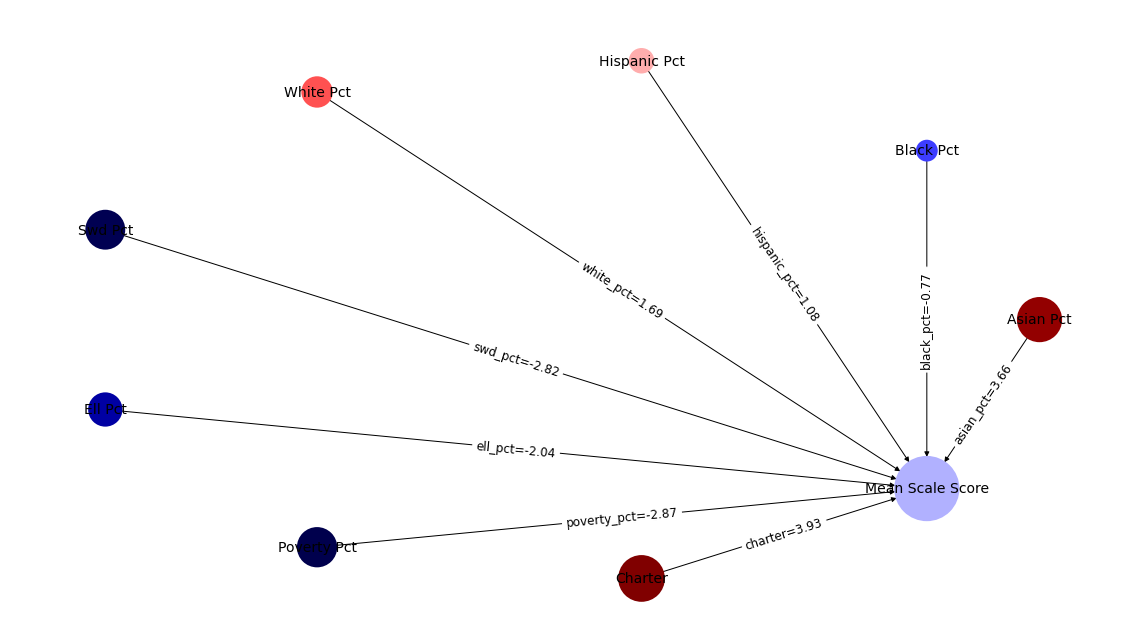

### Gaph of OLS coefficients

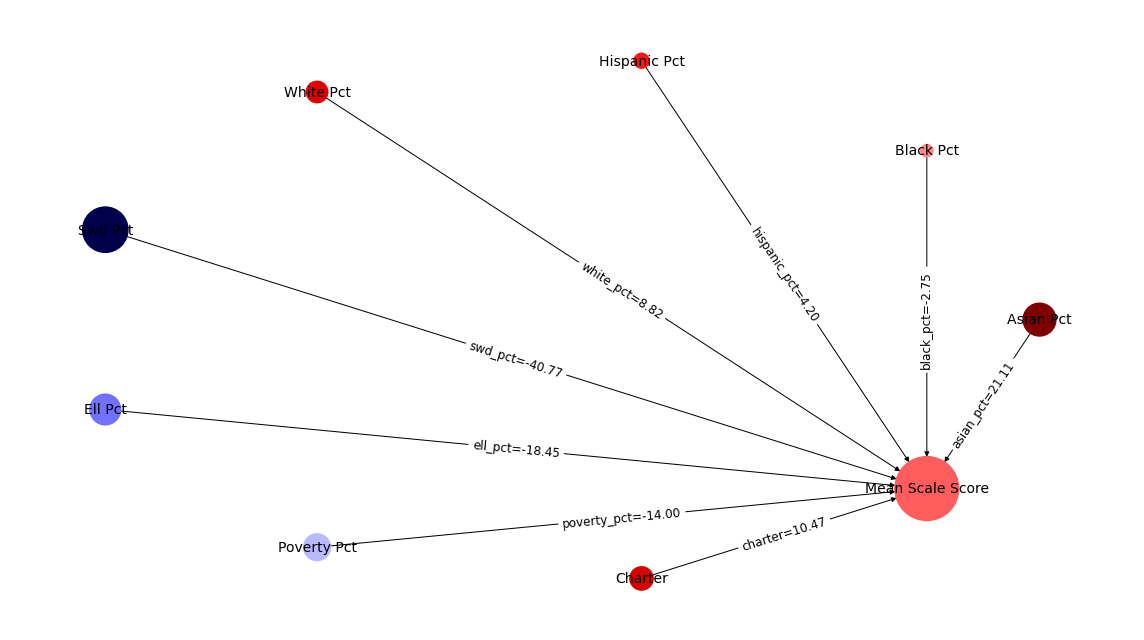

In [25]:
display(md("### Gaph of PLS coefficients"))
coefs = [x[0] for x in pls.coef_]
ui.network_map("mean_scale_score", factors, coefs , None)

display(md("### Gaph of OLS coefficients"))
coefs = [x for x in model.coef_]
ui.network_map("mean_scale_score", factors, coefs , None)